## Objective

The main objective of this challenge is to create a machine learning Model to classify/assess ,if a Twitter post is about covid-19 or not.

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:

!nvidia-smi


Fri May  8 13:40:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:

import torch
torch.cuda.is_available()



True

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#install simpletransformers Library
!pip install simpletransformers

In [0]:
# Import Libraries

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import *

from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax

from simpletransformers.classification.classification_model import ClassificationModel
from sklearn.metrics import mean_squared_error as mse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading **Datasets**

In [0]:
train = pd.read_csv("/content/drive/My Drive/Zindi_weekendz_hackathons/COVID-19 Tweet Classification/Data/updated_train.csv")
test  = pd.read_csv("/content/drive/My Drive/Zindi_weekendz_hackathons/COVID-19 Tweet Classification/Data/updated_test.csv")
sub = pd.read_csv("/content/drive/My Drive/Zindi_weekendz_hackathons/COVID-19 Tweet Classification/Data/updated_ss.csv")

In [51]:
# preview the data
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [52]:
test.head()

,ID,text
0,test_2,Why is explained in the video take a look
1,test_3,Ed Davey fasting for Ramadan No contest
2,test_4,Is Doja Cat good or do you just miss Nicki Minaj
3,test_8,How Boris Johnson s cheery wounded in action p...
4,test_9,Man it s terrible Not even a reason to get on ...


In [53]:
sub.head(1)

,ID,target
0,test_2,0


In [54]:
train.shape , test.shape 

((5287, 3), (1962, 2))

In [55]:
train['text'].apply(lambda x: len(x)).describe()

count    5287.000000
mean      110.442973
std        52.761904
min        19.000000
25%        76.000000
50%       108.000000
75%       122.000000
max       302.000000
Name: text, dtype: float64

In [56]:
test['text'].apply(lambda x: len(x)).describe()

count    1962.000000
mean      110.431193
std        55.119819
min        21.000000
25%        73.000000
50%       106.500000
75%       123.000000
max       288.000000
Name: text, dtype: float64

In [57]:
train['target'].value_counts()

0    2746
1    2541
Name: target, dtype: int64

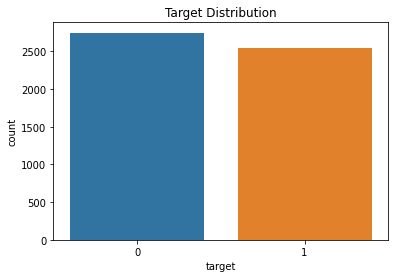

In [58]:
# visualize the target column
sns.countplot(x = 'target', data = train)
plt.title("Target Distribution")
plt.show()

From the above visualization , we can see almost both two classes are well balanced

In [59]:
train.isna().sum().any()

False

In [61]:
test.isna().sum().any()

False

Let's **preview** **the** **tweets**

In [62]:
## tweet posts about Covid-19
#
train[train['target'] == 1]['text'].values[:7]

array(['The bitcoin halving is cancelled due to',
       '266 Days No Digital India No Murder of e learning No 2g online business No Restore in J amp k',
       'India is likely to run out of the remaining RNA kits which are essential for testing in one week What is the gov',
       'Frontline health workers are critical in the fight against infectious diseases not just  They protect communit',
       'Maybe one of the distinguishing features of a good leader is that they are not using this present situation as a politic',
       'Article New tool on how to adapt our health messaging to a specific audience especially in the current',
       'Asks Chief Judge to Free Prisoners Due to  Threat via'],
      dtype=object)

In [63]:
## tweet posts not about Covid-19
#
train[train['target'] == 0]['text'].values[:7]

array(['MercyOfAllah In good times wrapped in its granular detail I challenge myself to find meaning and model the humility t',
       'In these tough times the best way to grow is to learn or in my case teach to help people learn to connect Sports and Anal',
       'FIFA has proposed allowing teams to make up to five substitutions per match to help players cope with the return to action',
       'Lovers of sports especially do you know why sometimes the time changes All this is done in the name of Daylight Saving Time DST which is the practice of setting the clocks forward one hour from standard time during the summer months and back again in the fall',
       'ig he kinda cute sometimes smh',
       'Contact centers are getting overwhelmed with customer questions during  Automate providing answers to the most common questions using SearchAI Answers through a chatbot or a voice assistant Setup Search Answers in a week or less',
       'The BEST REWARD for any Human Being on earth now 

Modelling

In [0]:
def get_model(model_type, model_name, n_epochs = 3, train_batch_size = 200, eval_batch_size = 210, seq_len = 100, lr = 1e-5):
  model = ClassificationModel(model_type, model_name,num_labels=1, args={'train_batch_size':train_batch_size,
                                                                         "eval_batch_size": eval_batch_size,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': n_epochs,
                                                                         'max_seq_length': seq_len,
                                                                         'regression': True,
                                                                         'manual_seed': 1,
                                                                         "learning_rate":lr,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,})
  return model

In [0]:
SEED = 1

In [0]:
tmp = pd.DataFrame()
tmp['text'] = train['text']
tmp['target'] = train['target']
tmp_test = test[['text']]
tmp_test['target'] = 0
tmp_trn, tmp_val = train_test_split(tmp, test_size=0.25, random_state=SEED)

In [70]:
model = get_model('roberta', 'roberta-large', n_epochs=3, train_batch_size=25, eval_batch_size=25, lr = 1e-5)
model.train_model(tmp_trn)
preds_val = model.eval_model(tmp_val)[1]
print(f"RMSE: {mse(tmp_val['target'], preds_val)**0.5}")
test_preds = model.eval_model(tmp_test)[1]
pv_1 = preds_val
pt_1 = test_preds

Running loss: 0.166170


Running loss: 0.135145


Running loss: 0.057956




RMSE: 0.2442174865258834


In [71]:
model = get_model('roberta', 'roberta-large', n_epochs= 2, train_batch_size=16, eval_batch_size=16, lr = 2e-5)
model.train_model(tmp_trn)
preds_val = model.eval_model(tmp_val)[1]
print(f"RMSE: {mse(tmp_val['target'], preds_val)**0.5}")
test_preds = model.eval_model(tmp_test)[1]
pv_2 = preds_val
pt_2 = test_preds

Running loss: 0.150105


Running loss: 0.071968




RMSE: 0.2447763007678596


In [72]:
model = get_model('roberta', 'roberta-large', n_epochs=5, train_batch_size=16, eval_batch_size=16, lr =1e-5 )
model.train_model(tmp_trn)
preds_val = model.eval_model(tmp_val)[1]
print(f"RMSE: {mse(tmp_val['target'], preds_val)**0.5}")
test_preds = model.eval_model(tmp_test)[1]
pv_3 = preds_val
pt_3 = test_preds

Running loss: 0.195589


Running loss: 0.210171


Running loss: 0.056116


Running loss: 0.013004


Running loss: 0.012467




RMSE: 0.25685917867459407


In [73]:
model = get_model('roberta', 'roberta-large', n_epochs=4, train_batch_size=16, eval_batch_size=16, lr =1e-5 )
model.train_model(tmp_trn)
preds_val = model.eval_model(tmp_val)[1]
print(f"RMSE: {mse(tmp_val['target'], preds_val)**0.5}")
test_preds = model.eval_model(tmp_test)[1]
pv_4 = preds_val
pt_4 = test_preds

Running loss: 0.150145


Running loss: 0.076826


Running loss: 0.102960


Running loss: 0.015178




RMSE: 0.23960240346797318


Blending 

In [74]:

pv = ((pv_1 * 0.3 + pv_2 * 0.7) * 0.3 + pv_3*0.7)*0.65 + pv_4*0.35
print(f"RMSE: {mse(tmp_val['target'], pv)**0.5}")

RMSE: 0.23697113333645767


In [0]:
tp = ((pt_1 * 0.3 + pt_2 * 0.7) * 0.3 + pt_3*0.7)*0.65 + pt_4*0.35

In [76]:

pd.Series(tp).describe()

count    1962.000000
mean        0.473942
std         0.497881
min        -0.062706
25%        -0.024156
50%         0.244020
75%         1.023709
max         1.094380
dtype: float64

In [0]:
ID_COL, TARGET_COL = sub.columns.tolist()

In [0]:
final_test_preds = tp
preds_df_final = test[[ID_COL]]
preds_df_final[TARGET_COL] = final_test_preds
SUB_FILE_NAME = 'simpletransformers1.csv'
preds_df_final.to_csv(SUB_FILE_NAME, index=False)

In [79]:
preds_df_final.head()

,ID,target
0,test_2,1.019592
1,test_3,-0.026280
2,test_4,-0.025217
3,test_8,1.058393
4,test_9,-0.030450


In [0]:

from google.colab import files
files.download(SUB_FILE_NAME)